In [34]:
using Revise
using Bilevel

using RigidBodyDynamics
using MeshCatMechanisms
using MeshCat
using ForwardDiff
using Plots
using LinearAlgebra
using StaticArrays
using Base.Threads

In [35]:
nthreads()

1

In [30]:
function get_barnesgrad()
    a1 = 75.196
    a3 = 0.12694
    a5 = 1.0345e-5
    a7 = 0.030234
    a9 = 3.5256e-5
    a11 = 0.25645
    a13 = 1.3514e-5
    a15 = -5.2375e-6
    a17 = 7.0e-10
    a19 = -1.6638e-6
    a21 = 0.0005
    a2 = -3.8112
    a4 = -2.0567e-3
    a6 = -6.8306
    a8 = -1.28134e-3
    a10 = -2.266e-7
    a12 = -3.4604e-3
    a14 = -28.106
    a16 = -6.3e-8
    a18 = 3.4054e-4
    a20 = -2.8673
    
    function eval_obj(x::AbstractArray{T}) where T
        x1 = x[1]
        x2 = x[2]
        y1 = x1*x2
        y2 = y1*x1
        y3 = x2^2
        y4 = x1^2

        f = a1 + a2*x1 + a3*y4 + a4*y4*x1 + a5*y4^2 +
            a6*x2 + a7*y1 + a8*x1*y1 + a9*y1*y4 + a10*y2*y4 +
            a11*y3 + a12*x2*y3 + a13*y3^2 + a14/(x2+1) +
            a15*y3*y4 + a16*y1*y4*x2 + a17*y1*y3*y4 + a18*x1*y3 +
            a19*y1*y3 + a20*exp(a21*y1)
        
        f
    end

    function eval_cons(x::AbstractArray{T}) where T
        x1 = x[1]
        x2 = x[2]
        y1 = x1*x2
        y2 = y1*x1
        y3 = x2^2
        y4 = x1^2
        
        c = zeros(T, 3)
        c[1] = 1 - y1/700.0
        c[2] = y4/25.0^2 - x2/5.0
        c[3] = (x1/500.0- 0.11) - (x2/50.0-1)^2
        
        c
    end
    
    fres = DiffResults.GradientResult(zeros(2))
    fcfg = ForwardDiff.GradientConfig(eval_obj, zeros(2))
    gres = DiffResults.JacobianResult(zeros(3), zeros(2))
    gcfg = ForwardDiff.JacobianConfig(eval_cons, zeros(2))
    function solver_fn(x)
        ForwardDiff.gradient!(fres, eval_obj, x, fcfg)
    
        J = eval_obj(x)
        gJ = ForwardDiff.gradient(eval_obj, x)
        
        HJ = ForwardDiff.hessian(eval_obj, x)
        
        ForwardDiff.jacobian!(gres, eval_cons, x, gcfg)
    
        g = DiffResults.value(gres)
        ceq = zeros(0)
        c = g
    
        dgdx = DiffResults.jacobian(gres)
        gceq = zeros(0,2)
        gc = dgdx
    
        J, ceq, c, gJ, gceq, gc, HJ
    end
    
    solver_fn
end

solver_fn = get_barnesgrad()

x0 = [10.0, 10.0]
options = Dict{String, Any}()
options["Derivative option"] = 1
options["Verify level"] = 1
xopt, info = Bilevel.snopt(solver_fn, 0, 3, x0, options)

display(info)
display(xopt)
display(isapprox(xopt[1], 49.5263; atol=1e-4))
display(isapprox(xopt[2], 19.6228; atol=1e-4))

x0 = [10.0, 10.0]
options = Dict{String, Any}()
options["num_fosteps"] = 0
options["num_sosteps"] = 10
options["c"] = 100.
options["c_fos"] = 1.
options["c_sos"] = 5.
xopt, info = Bilevel.auglag(solver_fn, 0, 3, x0, options)

display(info)
display(xopt)
display(isapprox(xopt[1], 49.5263; atol=1e-4))
display(isapprox(xopt[2], 19.6228; atol=1e-4))

"Finished successfully: optimality conditions satisfied"

2-element Array{Float64,1}:
 49.52630320092698 
 19.622837627545735

true

true

"Finished successfully"

2-element Array{Float64,1}:
 70.31175797733866
 39.54984329150459

false

false

In [31]:
urdf = joinpath("..", "urdf", "ball.urdf")
mechanism = parse_urdf(Float64, urdf)

floor = findbody(mechanism, "floor")
point = Point3D(default_frame(floor), SVector([0.,0.,0.]...))
normal = FreeVector3D(default_frame(floor), SVector([0.,0.,1.]...))
floor_obs = Obstacle(floor, point, normal, :xyz, .5)

obstacles = [floor_obs]
env = Environment(mechanism, urdf, obstacles)
ctrl! = (u,t,x) -> u[:] .= 0.
x0 = MechanismState(mechanism)
Δt = .01

0.01

In [32]:
q1 = [1., 0., 0., 0., 0., 0., 0.017]
v1 = [0., 0., 0., 1., 0., 0.]
N = 25

25

In [39]:
sim_data_indirect = get_sim_data_indirect(mechanism,env,Δt,relax_comp=false)
set_configuration!(x0, q1)
set_velocity!(x0, v1)
traj_indirect = Bilevel.simulate(sim_data_indirect, ctrl!, x0, N, verbose=1)

Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished s

(Array{Float64,1}[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.017], [1.0, 0.0, 1.46186e-10, -6.97934e-25, 0.01, -1.41364e-26, 0.016019], [1.0, 0.0, 4.45811e-10, -6.97934e-25, 0.02, -1.41364e-26, 0.014057], [1.0, 0.0, 9.18338e-10, -6.97934e-25, 0.03, -1.41364e-26, 0.011114], [1.0, 0.0, 1.60738e-9, -6.97934e-25, 0.04, -1.41364e-26, 0.00719], [1.0, 0.0, 2.62888e-9, -6.97934e-25, 0.05, -1.41364e-26, 0.002285], [1.0, -7.57036e-21, 3.6508e-9, 9.95264e-21, 0.0581995, 1.5613e-23, 5.07349e-8], [1.0, -7.57036e-21, 2.5933e-5, 9.95264e-21, 0.0647658, 1.5613e-23, 1.93701e-14], [1.0, -7.57036e-21, 0.000292603, 9.95264e-21, 0.0708415, 1.5613e-23, 1.93701e-14], [1.0, -7.57036e-21, 0.000559136, 9.95264e-21, 0.0764266, 1.5613e-23, 1.93701e-14]  …  [0.999997, -7.57036e-21, 0.00215551, 9.95262e-21, 0.0996338, 1.56128e-23, 1.93701e-14], [0.999997, -7.57036e-21, 0.00242112, 9.95262e-21, 0.101784, 1.56129e-23, 1.93701e-14], [0.999996, -7.57036e-21, 0.00268659, 9.95259e-21, 0.103444, 1.56128e-23, 1.93701e-14], [0.999995

In [38]:
sim_data_direct = get_sim_data_direct(mechanism,env,Δt,relax_comp=false)
set_configuration!(x0, q1)
set_velocity!(x0, v1)
traj_direct = Bilevel.simulate(sim_data_direct, ctrl!, x0, N, verbose=1)

Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished s

(Any[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.017], [1.0, 0.0, 4.90389e-6, 0.0, 0.01, 0.0, 0.016019], [1.0, 0.0, 1.4711e-5, 0.0, 0.02, 0.0, 0.014057], [1.0, 0.0, 2.94207e-5, 0.0, 0.0300001, 0.0, 0.011114], [1.0, 0.0, 4.90322e-5, 0.0, 0.0400002, 0.0, 0.00719], [1.0, 0.0, 7.35446e-5, 0.0, 0.0500003, 0.0, 0.002285], [1.0, 0.0, 9.02541e-5, 0.0, 0.0582002, 0.0, -4.90249e-7], [1.0, 0.0, 0.000100259, 0.0, 0.0647668, 0.0, -2.74032e-7], [1.0, 0.0, 0.000110503, 0.0, 0.0708428, 0.0, -1.41203e-7], [1.0, 0.0, 0.000120987, 0.0, 0.0764285, 0.0, -1.34538e-7]  …  [1.0, 0.0, 0.000188929, 0.0, 0.0996426, 0.0, -8.46763e-8], [1.0, 0.0, 0.000201093, 0.0, 0.101795, 0.0, -7.47194e-8], [1.0, 0.0, 0.000213496, 0.0, 0.103457, 0.0, -6.4292e-8], [1.0, 0.0, 0.00022614, 0.0, 0.104628, 0.0, -5.33937e-8], [1.0, 0.0, 0.000239024, 0.0, 0.105309, 0.0, -4.20245e-8], [1.0, 0.0, 0.000252149, 0.0, 0.105499, 0.0, -3.01841e-8], [1.0, 0.0, 0.000265366, 0.0, 0.1055, -7.48664e-13, -9.99634e-9], [1.0, 0.0, 0.000278583, 0.0, 0.1055, 1.0735

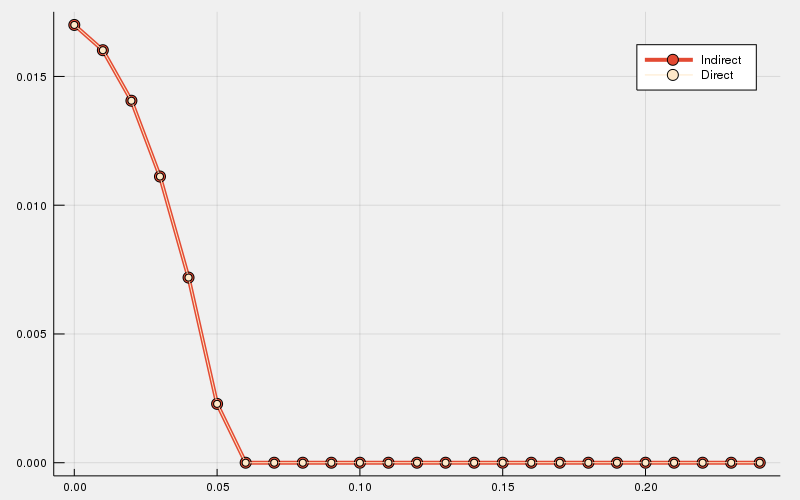

In [40]:
j = 7
clibrary(:Plots)
gr(size=(800,500), html_output_format=:png, 
    seriescolor=:magma,  background_color_legend=:white, 
    background=RGB(((240,240,240) ./ 255.)...));
plot(traj_indirect[6],traj_indirect[7][j,:],label="Indirect",seriescolor=RGB(((227,74,51) ./ 255.)...),linewidth=4,marker=6)
plot!(traj_direct[6],traj_direct[7][j,:],label="Direct",seriescolor=RGB(((254,232,200) ./ 255.)...),linewidth=0,marker=4)